In [1]:
import torch
import sklearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
import struct
import gzip
import os
import requests

In [2]:
# todos
# explain f1
# torch example (dataset, model, gpu, training loop); (conv)
# explain relations
# explain autograd and dag; similarity to sgd [make sgd example]
# show adam optim
# relu and activation functions
# batch norm
# monitor val loss (see sgd)

### Downloading MNIST Dataset from Offical Source

In [3]:
if not os.path.isdir('./data'):
    os.makedirs('./data')

In [4]:
urls = [
    'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
    'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
    'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
    'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz',
]
for url in urls:
    r = requests.get(url)
    with open(f'./data/{url.split("/")[-1]}', 'wb') as f:
        f.write(r.content)

The following structure below represents the training set `train-images-idx3-ubyte.gz`

```r
[offset] [type]          [value]          [description]
0000     32 bit integer  0x00000803(2051) magic number
0004     32 bit integer  60000            number of images
0008     32 bit integer  28               number of rows
0012     32 bit integer  28               number of columns
0016     unsigned byte   ??               pixel
0017     unsigned byte   ??               pixel
........
xxxx     unsigned byte   ??               pixel
```

### Reading MNIST data (crash course)

In [5]:
# sample content
with gzip.open('./data/train-images-idx3-ubyte.gz','rb') as f:
    print(f.read(4)) # 2051 (magic number
    print(f.read(4)) # 60000 (n samples) (backtick == b'\x60')
    print(f.read(4)) # 28 (n rows)
    print(f.read(4)) # 28 (n columns)
    print(f.read(4)) # 0, 0, 0, 0 (pixel data points)
    print(f.read(4)) # 0, 0, 0, 0 (pixel data points)

b'\x00\x00\x08\x03'
b'\x00\x00\xea`'
b'\x00\x00\x00\x1c'
b'\x00\x00\x00\x1c'
b'\x00\x00\x00\x00'
b'\x00\x00\x00\x00'


8 bits in 1 byte (value ranges from 0-255).  
Most people use hexadecimal (base 16) to represent bytes since it's more compact and divides evenly.  
The values 0-255 in hexdecimal is 0x00 - 0xFF.  
So each byte (== 8 bits) is represented by two hexadecimals digits.

Basically, the data starts on the 16th byte and everything before that is metadata.  
We show below how to read this.  

In [6]:
# https://stackoverflow.com/questions/39969045/parsing-yann-lecuns-mnist-idx-file-format

with gzip.open('./data/train-images-idx3-ubyte.gz','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    X_train = np.frombuffer(f.read(), dtype=np.dtype(np.uint8).newbyteorder('>'))
    X_train = X_train.reshape((size, nrows, ncols))

with gzip.open('./data/train-labels-idx1-ubyte.gz','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    y_train = np.frombuffer(f.read(), dtype=np.dtype(np.uint8).newbyteorder('>'))

with gzip.open('./data/t10k-images-idx3-ubyte.gz','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    X_test = np.frombuffer(f.read(), dtype=np.dtype(np.uint8).newbyteorder('>'))
    X_test = X_test.reshape((size, nrows, ncols))

with gzip.open('./data/t10k-labels-idx1-ubyte.gz','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    y_test = np.frombuffer(f.read(), dtype=np.dtype(np.uint8).newbyteorder('>'))

### Explaining the Code (ChatGPT)

In the given code snippet, the `struct.unpack` function is used to extract data from a binary file according to a specified format. The `struct` module in Python provides functions for working with C-style data structures represented as strings. It allows you to pack and unpack data in a binary format.

Let's break down the usage of `struct.unpack` in the code:

1. `magic, size = struct.unpack(">II", f.read(8))`
   Here, `f.read(8)` reads 8 bytes from the file object `f`. The format string `">II"` specifies the format of the data to be unpacked. `">"` indicates big-endian byte order, and `I` represents an unsigned integer of size 4 bytes. Therefore, `struct.unpack(">II", f.read(8))` reads 8 bytes from the file, interprets the first 4 bytes as `magic` and the next 4 bytes as `size`, and assigns the unpacked values to the variables `magic` and `size`.

2. `nrows, ncols = struct.unpack(">II", f.read(8))`
   This line is similar to the previous one. It reads another 8 bytes from the file and interprets the first 4 bytes as `nrows` and the next 4 bytes as `ncols`.

3. `data = np.frombuffer(f.read(), dtype=np.dtype(np.uint8).newbyteorder('>'))`
   Here, `f.read()` reads the remaining data from the file. The `frombuffer` function from the NumPy library is used to create an array from the binary data. The data type is specified as `np.uint8`, representing an 8-bit unsigned integer. The `newbyteorder('>')` method is used to ensure the data is interpreted in big-endian byte order.

4. `data = data.reshape((size, nrows, ncols))`
   Finally, the `data` array is reshaped using the dimensions obtained from the previous unpacking steps. It is reshaped into a 3-dimensional array with `size` rows, `nrows` height, and `ncols` width.

### Explaining Big vs Little Endian (ChatGPT)

There are two common types of endianness: big-endian and little-endian.

Big-endian: In big-endian systems, the most significant byte (the byte containing the highest order bits) is stored at the lowest memory address, while the least significant byte is stored at the highest memory address. This means that the data is stored from left to right, with the most significant byte first.

Little-endian: In little-endian systems, the least significant byte is stored at the lowest memory address, while the most significant byte is stored at the highest memory address. The data is stored from right to left, with the least significant byte first.

To understand this concept, let's consider a 4-byte integer value 0x12345678. Here's how it would be stored in memory based on the endianness:

Big-endian:

Memory Address: 0x00 0x01 0x02 0x03
Data Value: 0x12 0x34 0x56 0x78
Little-endian:

Memory Address: 0x00 0x01 0x02 0x03
Data Value: 0x78 0x56 0x34 0x12

Note that the endianness affects the ordering of bytes, but not the individual bits within each byte.

Endianness is important when data is shared between systems or when reading data from a binary file format. It's essential to ensure that both the sender and receiver of data interpret the bytes in the correct order to avoid data corruption or misinterpretation. Most modern systems, including x86 and ARM processors, use little-endian architecture. However, big-endian systems are still in use, particularly in certain network protocols or older hardware architectures.

In [7]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


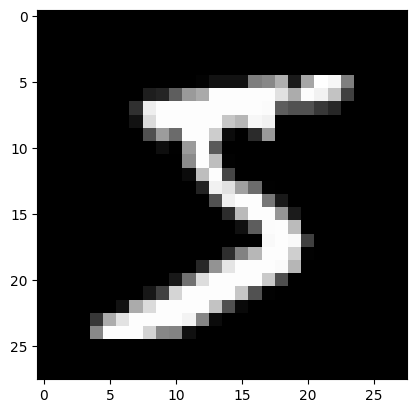

In [8]:
plt.imshow(X_train[0], cmap='gray')

In [9]:
print(y_train[0])

5


In [10]:
X_train_flattened = X_train.reshape(len(X_train), -1)
X_test_flattened = X_test.reshape(len(X_test), -1)

In [11]:
print(X_train_flattened.shape)
print(X_test_flattened.shape)

(60000, 784)
(10000, 784)


### Logistic Regression

In [12]:
%%time
classifier_sgd = SGDClassifier(
    loss='log_loss',
    penalty='l2',
    alpha=0.0001,
    l1_ratio=0.15,
    fit_intercept=True,
    max_iter=1000,
    tol=0.001,
    shuffle=True,
    verbose=0,
    epsilon=0.1,
    n_jobs=None,
    random_state=None,
    learning_rate='optimal',
    eta0=0.0,
    power_t=0.5,
    early_stopping=False,
    validation_fraction=0.1,
    n_iter_no_change=5,
    class_weight=None,
    warm_start=False,
    average=False,
)
classifier_sgd.fit(X_train_flattened, y_train)

CPU times: total: 2min 16s
Wall time: 2min 16s


SGDClassifier(loss='log_loss')

In [13]:
%%time
y_pred = classifier_sgd.predict(X_test_flattened)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.97      0.92      0.95      1037
           1       0.95      0.98      0.97      1100
           2       0.80      0.94      0.87       879
           3       0.81      0.95      0.87       859
           4       0.90      0.90      0.90       975
           5       0.86      0.85      0.85       902
           6       0.93      0.94      0.94       948
           7       0.81      0.98      0.89       852
           8       0.94      0.65      0.77      1413
           9       0.85      0.83      0.84      1035

    accuracy                           0.88     10000
   macro avg       0.88      0.89      0.88     10000
weighted avg       0.89      0.88      0.88     10000

CPU times: total: 250 ms
Wall time: 34.9 ms


### MLP

In [14]:
%%time
classifier_mlp = MLPClassifier(
    hidden_layer_sizes=(128,),
    activation='relu',
    solver='sgd',
    alpha=0.0001,
    batch_size=64,
    learning_rate='constant',
    learning_rate_init=1e-3,
    power_t=0.5,
    max_iter=200,
    shuffle=True,
    random_state=None,
    tol=0.0001,
    verbose=False,
    warm_start=False,
    momentum=0.9,
    nesterovs_momentum=True,
    early_stopping=False,
    validation_fraction=0.1,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-08,
    n_iter_no_change=10,
    max_fun=15000,
)
classifier_mlp.fit(X_train_flattened, y_train)

CPU times: total: 21min
Wall time: 2min 39s


MLPClassifier(batch_size=64, hidden_layer_sizes=(128,), solver='sgd')

In [15]:
%%time
y_pred = classifier_mlp.predict(X_test_flattened)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       975
           1       0.99      0.97      0.98      1154
           2       0.85      0.97      0.91       902
           3       0.90      0.95      0.93       962
           4       0.90      0.97      0.93       908
           5       0.87      0.98      0.92       791
           6       0.97      0.95      0.96       978
           7       0.93      0.97      0.95       989
           8       0.96      0.71      0.81      1314
           9       0.93      0.91      0.92      1027

    accuracy                           0.93     10000
   macro avg       0.93      0.94      0.93     10000
weighted avg       0.93      0.93      0.93     10000

CPU times: total: 375 ms
Wall time: 49.9 ms


### MLP VS SGD (ChatGPT)

Algorithm Family:

MLPClassifier: It is based on artificial neural networks, specifically multilayer perceptron (MLP) networks. MLP networks consist of multiple layers of nodes, including input, hidden, and output layers. They are known as universal function approximators and can handle complex non-linear relationships in data.
SGDClassifier: It is based on the stochastic gradient descent (SGD) optimization algorithm. SGD is a widely used optimization algorithm for training various types of models, including linear classifiers. It iteratively updates the model parameters using a small subset of the training data (mini-batches) to approximate the gradient of the loss function.
Flexibility:

MLPClassifier: It can model complex non-linear relationships and is capable of learning high-dimensional representations. It can handle a wide range of data types and can capture intricate patterns and interactions.
SGDClassifier: It is a linear classifier and is generally better suited for simpler, linearly separable problems. It is less flexible in terms of modeling complex relationships and may not perform as well on highly non-linear datasets.
Training:

MLPClassifier: Training an MLP model can be computationally expensive, especially for large datasets and complex architectures. It often requires more data and longer training times to achieve optimal performance. It may also be prone to overfitting if not properly regularized.
SGDClassifier: Training an SGD model is generally faster and more efficient, especially for large-scale datasets. It is computationally less demanding and can handle large amounts of data efficiently. However, it may require careful hyperparameter tuning to achieve optimal performance.
Interpretability:

MLPClassifier: MLP models are often considered as black boxes, meaning they can be challenging to interpret. The hidden layers and the complex interactions between nodes make it difficult to understand the internal workings and the importance of individual features.
SGDClassifier: SGD models, being linear classifiers, offer greater interpretability. The model coefficients directly represent the feature importance and can provide insights into the relationships between features and the target variable.

### XGB

In [16]:
%%time
classifier_xgb = XGBClassifier() # too many params to list lol
classifier_xgb.fit(X_train_flattened, y_train)

CPU times: total: 39min 18s
Wall time: 2min 51s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [17]:
%%time
y_pred = classifier_xgb.predict(X_test_flattened)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       993
           1       0.99      0.99      0.99      1136
           2       0.98      0.98      0.98      1033
           3       0.98      0.98      0.98      1013
           4       0.98      0.98      0.98       973
           5       0.98      0.98      0.98       886
           6       0.98      0.98      0.98       955
           7       0.97      0.98      0.98      1023
           8       0.98      0.98      0.98       972
           9       0.97      0.97      0.97      1016

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

CPU times: total: 953 ms
Wall time: 86.8 ms


### Why Better?

- data is nonlinear  
- logr can only model linear relationship between Y ~ X  
- xgb is an ensemble method that can model nonlinearities and interactions between features  
- decision trees also have some inherent robustness against by outliers  
- ensemble learning also reduce both bias and var of a model  

to improve logr performance, one would need careful feature engineering including:
- nonlinear transformations
- finding interactions between features
- handling outliers

### Refresher / Background

Machine Learning can broadly fall into these categories:

- Unsupervised $(X, ?)$
- Supervised $(X, y)$
    
    Say we have want to create a predictive model $f$ s.t. $\hat{y}_\theta = f(X, \theta)$  
    We define the loss function to be some distance function $D$ between the true value $y$ and predicted value $\hat{y}$ s.t. $L(\theta) = D(y, \hat{y}_\theta)$  
    In order to "fit" or "optimize" the model, our goal is to minimize the loss.  
    Different supervised learning problems uses different loss functions.  

    - Regression (y is continuous) (losses: squared error, abosolute error, huber)
    - Classification  (y is discrete) (losses: cross-entropy, log, hinge)
        - multi-label
        - single-label
            - binary
            - multi-class <- our MNIST problem falls here



Many of our supervised learning problems is trying to close the discrepancy between predicted and actual outcomes, which can be simplified as the minimization of a loss function.

Some machine learning algorithms can directly solve for a closed solution for the model weights that minimizes the loss (i.e., linear/logistic regression).

However, when it comes to more complex models, a closed solution may not always be available. Neural networks, can be seen as a generalized version of linear/logistic regression where there are many nonlinearities. Thus we employ a different technique known as gradient descent to solve for these.

This is an optimization algorithm that iteratively:

    - Finds the gradient of the loss function with respect to the weights
    - Updates the weights in the opposite direction of the gradient
    
Mathematically, this is seen as:  
$\theta_{new} = \theta_{old} - \text{learning_rate} * \nabla{f(\theta_{old}})$


### Neural Nets Intro

<img src='./perceptron.png' />

<img src='./network.png' />

<img src='./backprop.gif' />

<img src="./autograd.png" style="background-color: white;" />

### Recommended Watch

3Blue1Brown
1. [What is a Neural Network](https://youtu.be/aircAruvnKk)
2. [Gradient Descent](https://youtu.be/IHZwWFHWa-w)
3. [Backpropagation Overview](https://youtu.be/Ilg3gGewQ5U)
4. [Backpropagation Calculus](https://youtu.be/tIeHLnjs5U8)



### Pytorch Autograd (Crash Course)

Recommended Sources
- https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html
- https://pytorch.org/tutorials/beginner/introyt/autogradyt_tutorial.html
- https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html
- https://pytorch.org/blog/computational-graphs-constructed-in-pytorch/

In [18]:
array = np.array([[1, 2],[3, 4]])
tensor = torch.tensor(array)
tensor

tensor([[1, 2],
        [3, 4]], dtype=torch.int32)

Two major differences between the two:
1. tensors stores automatically computed gradients between operations
2. tensors leverage gpu support

In [19]:
a = torch.tensor([2., 3.], requires_grad=True) # default is False
b = torch.tensor([6., 4.], requires_grad=True)

In [20]:
print(a.grad)
print(b.grad)

None
None


In [21]:
Q = 3*a**3 - b**2

$\frac{\delta Q}{\delta a} = 9 a^2 = [36, 81]$

$\frac{\delta Q}{\delta b} = -2 b = [-12, -8]$

In [22]:
external_grad = torch.tensor([1., 1.]) # this value is multiplied element wise to final answer
Q.backward(gradient=external_grad)

In [23]:
print(a.grad)
print(b.grad)

tensor([36., 81.])
tensor([-12.,  -8.])


### Hands On Pytorch

In [24]:
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn

In [25]:
class MNISTDataset:
    def __init__(self, X, y, add_channel_dimension=False):
        assert X.shape[0] == len(y)
        self.X = torch.tensor(X, dtype=torch.float32) # required dtype (too high precision will be slow)
        self.y = torch.tensor(y, dtype=torch.int64) # required dtype

        if add_channel_dimension: # for CNNs
            self.add_channel_dimension()

    def __len__(self):
        return len(self.y)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

    def add_channel_dimension(self):
        self.X = self.X.reshape(-1, 1, 28, 28)

In [26]:
dataset_train = MNISTDataset(X_train, y_train)
dataset_test = MNISTDataset(X_test, y_test)

In [27]:
X1, y1 = dataset_train[0]
print(X1.shape)
print(y1)

torch.Size([28, 28])
tensor(5)


In [28]:
class GenericDeepLearningModel:
    def __init__(self, neural_net, loss_fn, optim, device=torch.device('cpu')):
        self.neural_net = neural_net.to(device)
        self.loss_fn = loss_fn
        self.optim = optim
        self.device = device

    def train(self, dataset, epochs=10, batch_size=64, validation_fraction=0.8):
        dataset_train, dataset_val = random_split(dataset, lengths=[1-validation_fraction, validation_fraction])
        # Fun Fact: `validation_fraction` also a parameter in scikit-learn SGDClassifier

        for epoch in range(epochs):
            self.neural_net.train() # Dropout and BatchNorm layers will behave differently
            loss_train = 0
            dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True) # dl aggregates small batches of data
            for X, y in dataloader:
                X, y = X.to(self.device), y.to(self.device) # move to device
                y_pred = self.neural_net(X) # forward prop
                loss = self.loss_fn(y_pred, y) # get error
                loss.backward() # backprop
                loss_train += self.loss_fn(y_pred, y).item()
                self.optim.step() # update weights toward gradient where loss is min
                self.optim.zero_grad() # zero the gradients for next iter
            loss_train /= len(dataloader)

            self.neural_net.eval() # Dropout and BatchNorm layers will behave differently
            loss_val = 0
            dataloader = DataLoader(dataset, batch_size=batch_size) # dl aggregates small batches of data
            with torch.no_grad(): # stop tracking gradients for faster speed / lower memory
                for X, y in dataloader:
                    X, y = X.to(self.device), y.to(self.device) # move to device
                    y_pred = self.neural_net(X) # forward prop
                    loss_val += self.loss_fn(y_pred, y).item() # get error
            loss_val /= len(dataloader)

            print(f'Epoch: {epoch} | Train Loss: {loss_train} | Val Loss: {loss_val}')

    def evaluate(self, dataset):
        self.neural_net.eval()
        dataloader = DataLoader(dataset_train, batch_size=len(dataset))
        X, y = next(iter(dataloader))
        with torch.no_grad():
            y_pred = self.neural_net(X.to(self.device))
            loss = self.loss_fn(y_pred, y.to(self.device))
        return y.numpy(), y_pred.argmax(axis=1).cpu().numpy(), loss.cpu().numpy()

### A Linear Network

In [29]:
class SimpleLinearNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layer1 = nn.Linear(28*28, 10) # https://pytorch.org/docs/stable/generated/torch.nn.Linear.html

    def forward(self, x):
        x = self.flatten(x)
        x = self.layer1(x)
        return x

In [30]:
neural_net = SimpleLinearNet()
model = GenericDeepLearningModel(
    neural_net,
    nn.CrossEntropyLoss(), # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
    torch.optim.SGD(neural_net.parameters(), lr=1e-3),
    torch.device('cuda')
)

In [31]:
%%time
model.train(dataset_train)

Epoch: 0 | Train Loss: 40.309708188188836 | Val Loss: 27.563773762188486
Epoch: 1 | Train Loss: 18.879860138956538 | Val Loss: 19.302958558109015
Epoch: 2 | Train Loss: 17.188329904478916 | Val Loss: 27.769250177117044
Epoch: 3 | Train Loss: 17.090964487892517 | Val Loss: 23.671133071363496
Epoch: 4 | Train Loss: 13.935152999581174 | Val Loss: 23.29815293146349
Epoch: 5 | Train Loss: 14.806204048877067 | Val Loss: 19.170209091990742
Epoch: 6 | Train Loss: 14.554472452148477 | Val Loss: 102.45612598939745
Epoch: 7 | Train Loss: 16.065015227870738 | Val Loss: 23.26684105053131
Epoch: 8 | Train Loss: 12.62532473054338 | Val Loss: 28.80706609162822
Epoch: 9 | Train Loss: 12.247026356610846 | Val Loss: 32.01378312980188
CPU times: total: 15.1 s
Wall time: 13.8 s


In [32]:
y, y_pred, loss = model.evaluate(dataset_test)
print(loss)
print(classification_report(y, y_pred))

30.788513
              precision    recall  f1-score   support

           0       0.66      1.00      0.79      1001
           1       0.91      0.96      0.94      1127
           2       0.94      0.54      0.69       991
           3       0.45      0.95      0.61      1032
           4       0.96      0.83      0.89       980
           5       0.91      0.69      0.79       863
           6       0.92      0.88      0.90      1014
           7       0.98      0.79      0.88      1070
           8       0.91      0.35      0.51       944
           9       0.86      0.74      0.80       978

    accuracy                           0.78     10000
   macro avg       0.85      0.77      0.78     10000
weighted avg       0.85      0.78      0.78     10000



### A Nonlinear Network

In [33]:
class NonLinearNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layer1 = nn.Linear(28*28, 256) # https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
        self.layer2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.layer1(x)
        x = self.layer2(x)
        return x

In [34]:
neural_net = NonLinearNet()
model = GenericDeepLearningModel(
    neural_net,
    nn.CrossEntropyLoss(), # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
    torch.optim.SGD(neural_net.parameters(), lr=1e-3),
    torch.device('cuda')
)

In [35]:
%%time
model.train(dataset_train)

Epoch: 0 | Train Loss: 9.012587685058726 | Val Loss: 2.6126150126948255
Epoch: 1 | Train Loss: 1.8587109403724367 | Val Loss: 1.8618727823389745
Epoch: 2 | Train Loss: 1.201519498561925 | Val Loss: 1.367805096914551
Epoch: 3 | Train Loss: 0.9419910249974024 | Val Loss: 1.7320785754397987
Epoch: 4 | Train Loss: 0.7969243927521908 | Val Loss: 1.2164581948474271
Epoch: 5 | Train Loss: 0.7177809138802138 | Val Loss: 0.9669188527640566
Epoch: 6 | Train Loss: 0.6241747729995466 | Val Loss: 0.8164463173677482
Epoch: 7 | Train Loss: 0.5663915293370473 | Val Loss: 0.7931393837449012
Epoch: 8 | Train Loss: 0.5356573009110511 | Val Loss: 0.8314514110671051
Epoch: 9 | Train Loss: 0.510583781934482 | Val Loss: 0.6994510111885507
CPU times: total: 14.5 s
Wall time: 13.3 s


In [36]:
y, y_pred, loss = model.evaluate(dataset_test)
print(loss)
print(classification_report(y, y_pred))

0.6797344
              precision    recall  f1-score   support

           0       0.97      0.92      0.95      1001
           1       0.91      0.98      0.94      1127
           2       0.91      0.85      0.88       991
           3       0.76      0.93      0.84      1032
           4       0.87      0.94      0.90       980
           5       0.86      0.82      0.84       863
           6       0.94      0.92      0.93      1014
           7       0.92      0.87      0.90      1070
           8       0.87      0.72      0.79       944
           9       0.86      0.87      0.86       978

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



### Slightly More Complex Network

In [37]:
class ComplexNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layer1 = nn.Linear(28*28, 256) # https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
        self.layer2 = nn.Linear(256, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.bn = nn.BatchNorm1d(256)

    def forward(self, x):
        x = self.flatten(x)
        x = self.layer1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer2(x)
        return x

In [38]:
neural_net = ComplexNet()
model = GenericDeepLearningModel(
    neural_net,
    nn.CrossEntropyLoss(), # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
    torch.optim.SGD(neural_net.parameters(), lr=1e-3),
    torch.device('cuda')
)

In [39]:
%%time
model.train(dataset_train)

Epoch: 0 | Train Loss: 2.035435875679584 | Val Loss: 1.5648306749268635
Epoch: 1 | Train Loss: 1.4361732855756233 | Val Loss: 1.1783731187711646
Epoch: 2 | Train Loss: 1.1583283790882597 | Val Loss: 0.9707393722493511
Epoch: 3 | Train Loss: 0.9952280993791337 | Val Loss: 0.8446643254650172
Epoch: 4 | Train Loss: 0.8866599582611246 | Val Loss: 0.7582155691344601
Epoch: 5 | Train Loss: 0.80497352588684 | Val Loss: 0.6920147496245818
Epoch: 6 | Train Loss: 0.749968855304921 | Val Loss: 0.6410865177795577
Epoch: 7 | Train Loss: 0.7023762816444357 | Val Loss: 0.5989109164139609
Epoch: 8 | Train Loss: 0.6637834835242717 | Val Loss: 0.5643923942531858
Epoch: 9 | Train Loss: 0.6339575144204688 | Val Loss: 0.5410071620618356
CPU times: total: 16 s
Wall time: 14.6 s


In [40]:
y, y_pred, loss = model.evaluate(dataset_test)
print(loss)
print(classification_report(y, y_pred))

0.5314726
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      1001
           1       0.86      0.98      0.91      1127
           2       0.90      0.84      0.87       991
           3       0.85      0.83      0.84      1032
           4       0.90      0.90      0.90       980
           5       0.87      0.79      0.83       863
           6       0.89      0.94      0.92      1014
           7       0.90      0.90      0.90      1070
           8       0.88      0.80      0.84       944
           9       0.86      0.87      0.86       978

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [41]:
def conv_dim(in_dim, kernel, stride=1, padding=0, dilation=1):
    out_dim = int((in_dim + 2*padding - dilation*(kernel - 1) - 1)/stride + 1)
    return out_dim

dim = conv_dim(28, 3, stride=2)
dim = conv_dim(dim, 3, stride=1)
print(dim)

11


### CNN

In [42]:
dataset_train.add_channel_dimension()
dataset_test.add_channel_dimension()

In [43]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential( # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
            nn.Conv2d(1, 16, 3, stride=2), # 
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.layer3 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*11*11, 10)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

In [44]:
neural_net = CNN()
model = GenericDeepLearningModel(
    neural_net,
    nn.CrossEntropyLoss(), # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
    torch.optim.SGD(neural_net.parameters(), lr=1e-3),
    torch.device('cuda')
)

In [45]:
%%time
model.train(dataset_train)

Epoch: 0 | Train Loss: 1.3475130422318236 | Val Loss: 0.863038068418818
Epoch: 1 | Train Loss: 0.6998353286626491 | Val Loss: 0.5928574696437382
Epoch: 2 | Train Loss: 0.5260738112190937 | Val Loss: 0.4832980863448145
Epoch: 3 | Train Loss: 0.4411310204800139 | Val Loss: 0.4183460044057003
Epoch: 4 | Train Loss: 0.38961710812563594 | Val Loss: 0.3761330754565659
Epoch: 5 | Train Loss: 0.352353443332175 | Val Loss: 0.3460389236365554
Epoch: 6 | Train Loss: 0.32477523378552275 | Val Loss: 0.3242693642563403
Epoch: 7 | Train Loss: 0.3023293821260016 | Val Loss: 0.30434898843071356
Epoch: 8 | Train Loss: 0.28412980110721386 | Val Loss: 0.2880167916758673
Epoch: 9 | Train Loss: 0.2691962500201895 | Val Loss: 0.27557560721281243
CPU times: total: 20.7 s
Wall time: 19.5 s


In [46]:
y, y_pred, loss = model.evaluate(dataset_test)
print(loss)
print(classification_report(y, y_pred))

0.27075937
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1001
           1       0.95      0.97      0.96      1127
           2       0.92      0.92      0.92       991
           3       0.93      0.90      0.91      1032
           4       0.94      0.95      0.95       980
           5       0.91      0.94      0.92       863
           6       0.95      0.96      0.95      1014
           7       0.95      0.92      0.93      1070
           8       0.92      0.88      0.90       944
           9       0.90      0.91      0.90       978

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



### ResNet

In [47]:
from torchvision.models import resnet50

neural_net = resnet50()
neural_net._modules['conv1'] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model = GenericDeepLearningModel(
    neural_net,
    nn.CrossEntropyLoss(), # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
    torch.optim.SGD(neural_net.parameters(), lr=1e-3),
    torch.device('cuda')
)

In [48]:
%%time
model.train(dataset_train)

Epoch: 0 | Train Loss: 2.789503958631069 | Val Loss: 2.16271891459219
Epoch: 1 | Train Loss: 1.977960412172561 | Val Loss: 1.7490277604253561
Epoch: 2 | Train Loss: 1.5177641029053546 | Val Loss: 1.2651890675142121
Epoch: 3 | Train Loss: 1.0693497879708067 | Val Loss: 0.8981671008918839
Epoch: 4 | Train Loss: 0.7625468489020428 | Val Loss: 0.6419392328685535
Epoch: 5 | Train Loss: 0.5773817039233573 | Val Loss: 0.5058422752979722
Epoch: 6 | Train Loss: 0.4585145971083895 | Val Loss: 0.418229294658851
Epoch: 7 | Train Loss: 0.36243749069089587 | Val Loss: 0.3608058339306541
Epoch: 8 | Train Loss: 0.29723355388070677 | Val Loss: 0.3110300861040889
Epoch: 9 | Train Loss: 0.2468104509914175 | Val Loss: 0.2733064153646705
CPU times: total: 2min 41s
Wall time: 2min 40s


In [49]:
y, y_pred, loss = model.evaluate(dataset_test)
print(loss)
print(classification_report(y, y_pred))

0.27195197
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1001
           1       0.96      0.97      0.96      1127
           2       0.91      0.90      0.91       991
           3       0.90      0.88      0.89      1032
           4       0.91      0.92      0.91       980
           5       0.85      0.93      0.89       863
           6       0.95      0.94      0.95      1014
           7       0.92      0.90      0.91      1070
           8       0.90      0.84      0.87       944
           9       0.89      0.90      0.89       978

    accuracy                           0.92     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.92      0.92      0.92     10000

